In [1]:
import os
import sharedmem
import ctypes
import time
import numpy as np
import matplotlib.pyplot as plt
import popeye.utilities_cclab as utils
from popeye.visual_stimulus import VisualStimulus, simulate_bar_stimulus, resample_stimulus
from popeye.spinach import generate_og_receptive_fields
import popeye.models_cclab as prfModels
import threading
import multiprocessing as mp
# import popeye.css as css
# import popeye.utilities_cclab as utils
import nibabel as nib
from ipywidgets import interact, widgets
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor, as_completed
from itertools import product

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
viewing_distance = 38.0
screen_width = 25.0
thetas = np.arange(0, 360, 90)
thetas = np.insert(thetas, 0, -1)
thetas = np.append(thetas, -1)
num_blank_steps = 30
num_bar_steps = 30
ecc = 12
tr_length = 1.0
frames_per_tr = 1.0
scale_factor = 1.0
pixels_across = 100
pixels_down = 100
dtype = ctypes.c_int16

# Simulate the bar stimulus
bar = simulate_bar_stimulus(pixels_across, pixels_down, viewing_distance, 
                            screen_width, thetas, num_bar_steps, num_blank_steps, ecc)

# Create the visual stimulus
stimulus = VisualStimulus(stim_arr=bar,
                           viewing_distance=viewing_distance, 
                           screen_width=screen_width, 
                           scale_factor=scale_factor, 
                           tr_length=tr_length, 
                           dtype=dtype)

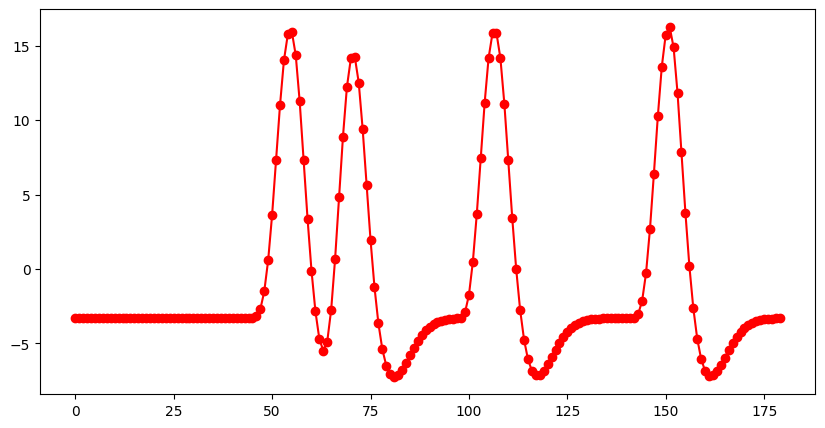

In [3]:
# Initialize a gaussian model
model = prfModels.CompressiveSpatialSummationModel(stimulus, utils.double_gamma_hrf)

model.hrf_delay = 0
model.mask_size = 6

# Generate simulated data
n_vox = 25
# Generate random pRF estimates for each voxel
ground_truth = np.empty((n_vox, 9))
ground_truth[:, 0] = np.random.uniform(-10, 10, n_vox) # x
ground_truth[:, 1] = np.random.uniform(-10, 10, n_vox) # y
ground_truth[:, 2] = np.random.uniform(0.25, 5, n_vox) # sigma
ground_truth[:, 3] = np.random.uniform(0.01, 1.0, n_vox) # exponent
ground_truth[:, 4] = np.random.uniform(0, 5, n_vox) # beta
ground_truth[:, 5] = np.random.uniform(-1, 1, n_vox) # baseline
ground_truth[:, 6] = np.ones((1,n_vox)) # R2
ground_truth[:, 7] = np.sqrt(ground_truth[:, 0]**2 + ground_truth[:, 1]**2) # eccentricity
ground_truth[:, 8] = np.mod(np.arctan2(ground_truth[:, 1], ground_truth[:, 0]),2*np.pi) # theta
# Create a holder for pRF estimates from the model
ballpark_estimates = np.empty((n_vox, ground_truth.shape[-1]))
param_estimates = np.empty((n_vox, ground_truth.shape[-1]))

sim_data = np.empty((n_vox, stimulus.stim_arr.shape[-1]))
for i in range(n_vox):
    sim_data[i, :] = model.generate_prediction(ground_truth[i,0], ground_truth[i,1], 
                                               ground_truth[i,2], ground_truth[i,3], 
                                               ground_truth[i,4], ground_truth[i,5])

plt.figure(figsize=(10, 5))
plt.plot(sim_data[1, :], 'ro-')
plt.show()

In [ ]:
ground_truth[:, 1]

In [ ]:
ground_truth[:, 0]

In [4]:
Ns=15
x_g = utils.grid_slice(-12, 12, Ns, dryrun=True)
y_g = utils.grid_slice(-12, 12, Ns, dryrun=True)
s_g = utils.grid_slice(0.1, 5.25, Ns, dryrun=True)
n_g = utils.grid_slice(0.01, 1.0, Ns, dryrun=True)

def ErrFunc(data, prediction):
    return np.nansum(data-prediction)**2
err_grid = np.empty((len(x_g), len(y_g), len(s_g), len(n_g)))
for (ix, iy, isig, iexp) in product(range(len(x_g)), range(len(y_g)), range(len(s_g)), range(len(n_g))):
    pred_this = model.generate_prediction(x_g[ix],y_g[iy], s_g[isig], n_g[iexp], ground_truth[1,4], ground_truth[1,5], unscaled=False)
    err_grid[ix, iy, isig, iexp] = ErrFunc(sim_data[1, :], pred_this)

zz = ErrFunc(sim_data[1, :], sim_data[1, :])

In [ ]:
# Visualize the error grid as a 3d plot
# Make this interactive with the view angles
@interact(elev=widgets.IntSlider(min=0, max=180, step=1, value=0),
            azim=widgets.IntSlider(min=0, max=180, step=1, value=0),
            x_var=widgets.Dropdown(options=['x', 'y', 'sigma', 'exponent'], value='x', description = 'X-axis'),
            y_var=widgets.Dropdown(options=['x', 'y', 'sigma', 'exponent'], value='y', description = 'Y-axis'))
def plot_err(elev, azim, x_var, y_var):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    if x_var == 'x':
        if y_var == 'y':
            X, Y = np.meshgrid(x_g, y_g)
            Z = np.mean(err_grid, axis=(2,3))
            xx, yy = ground_truth[1, 0], ground_truth[1, 1]
        elif y_var == 'sigma':
            X, Y = np.meshgrid(x_g, s_g)
            Z = np.mean(err_grid, axis=(1,3))
            xx, yy = ground_truth[1, 0], ground_truth[1, 2]
        elif y_var == 'exponent':
            X, Y = np.meshgrid(x_g, n_g)
            Z = np.mean(err_grid, axis=(1,2))
            xx, yy = ground_truth[1, 0], ground_truth[1, 3]
    elif x_var == 'y':
        if y_var == 'x':
            X, Y = np.meshgrid(y_g, x_g)
            Z = np.mean(err_grid, axis=(2,3))
            xx, yy = ground_truth[1, 1], ground_truth[1, 0]
        elif y_var == 'sigma':
            X, Y = np.meshgrid(y_g, s_g)
            Z = np.mean(err_grid, axis=(0,3))
            xx, yy = ground_truth[1, 1], ground_truth[1, 2]
        elif y_var == 'exponent':
            X, Y = np.meshgrid(y_g, n_g)
            Z = np.mean(err_grid, axis=(0,2))
            xx, yy = ground_truth[1, 1], ground_truth[1, 3]
    elif x_var == 'sigma':
        if y_var == 'x':
            X, Y = np.meshgrid(s_g, x_g)
            Z = np.mean(err_grid, axis=(1,3))
            xx, yy = ground_truth[1, 2], ground_truth[1, 0]
        elif y_var == 'y':
            X, Y = np.meshgrid(s_g, y_g)
            Z = np.mean(err_grid, axis=(0,3))
            xx, yy = ground_truth[1, 2], ground_truth[1, 1]
        elif y_var == 'exponent':
            X, Y = np.meshgrid(s_g, n_g)
            Z = np.mean(err_grid, axis=(0,1))
            xx, yy = ground_truth[1, 2], ground_truth[1, 3]
    elif x_var == 'exponent':
        if y_var == 'x':
            X, Y = np.meshgrid(n_g, x_g)
            Z = np.mean(err_grid, axis=(1,2))
            xx, yy = ground_truth[1, 3], ground_truth[1, 0]
        elif y_var == 'y':
            X, Y = np.meshgrid(n_g, y_g)
            Z = np.mean(err_grid, axis=(0,2))
            xx, yy = ground_truth[1, 3], ground_truth[1, 1]
        elif y_var == 'sigma':
            X, Y = np.meshgrid(n_g, s_g)
            Z = np.mean(err_grid, axis=(0,1))
            xx, yy = ground_truth[1, 3], ground_truth[1, 2]
    z_min, z_max = np.min(Z), np.max(Z)
    ax.bar3d(xx, yy, z_min, 0.1, 0.1, z_max-z_min, color='k')
    ax.plot_surface(X, Y, Z, cmap='RdBu_r')
    ax.view_init(elev=elev, azim=azim)
    ax.set_xlabel(x_var)
    ax.set_ylabel(y_var)
    ax.set_zlabel('Error')
    plt.show()

plot_err(0, 0, 'x', 'y')

In [ ]:
plt.figure()
plt.hist(err_grid.flatten(), bins=100)
plt.show()